## Analysis of r/place 2023 Dataset

Hey there! This notebook dives into the r/place 2023 event data. We're going to look at how people participated, what colors they picked, and if we can spot any patterns that might show us bot activity or how bots influenced the art. Our aim is to pull out some cool insights by visualizing the data and some statistical analysis.

## Dataset Overview

The dataset contains information about each pixel placed on the canvas, including the timestamp, user ID, pixel coordinates, and pixel color.

### Libraries We're Using

- **Dask**: Helps us work with huge datasets by parallel computing.
- **Pandas**: Our go-to for slicing and dicing the data.
- **Matplotlib**: Lets us create all sorts of charts to see what's going on.
- **tqdm**: Shows us progress bars so we know how long things will take.

In [4]:
!pip uninstall s3fs -y
!pip install s3fs
!pip install --upgrade numexpr


Found existing installation: s3fs 0.4.2
Uninstalling s3fs-0.4.2:
  Successfully uninstalled s3fs-0.4.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.9/170.9 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.10.0
    Uninstalling fsspec-2023.10.0:
      Successfully uninstalled fsspec-2023.10.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.2/375.2 kB 26.3 MB/s eta 0:00:00
  Attempting uninstall: numexpr
    Found existing installation: numexpr 2.7.3
    Uninstalling numexpr-2.7.3:
      Successfully uninstalled numexpr-2.7.3


In [1]:
import dask
import dask.dataframe as dd
import os
import pandas as pd
import numpy as np
from tqdm.dask import TqdmCallback
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
from dask.distributed import Client, progress
import json
from tqdm import tqdm
import matplotlib.ticker as ticker
from matplotlib.patches import Circle, Polygon
import re

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Converting CSV Data to Parquet

To efficiently handle and process the large dataset of r/place 2023, we can convert the CSV files, compressed with gzip, into Parquet format. Parquet is a columnar storage file format.

### Why Parquet Rocks

- **Efficiency**: Parquet files don't take up much space and let us work fast, even with complicated data.
- **Speed**: It's way quicker to read data from Parquet files than CSVs, a big win for us especially as we have large dataset.
- **Flexibility**: Lots of data tools work with Parquet, so we can analyze our data in many different ways.

Below is the Python function to perform this conversion, along with the execution loop that processes a list of CSV file URLs.


In [ ]:
#Function to take the CSV file URLs links and convert them into parquet files
def convert_csv_to_parquet(url, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    file_name = url.split("/")[-1].replace(".gzip", "")
    parquet_path = os.path.join(output_dir, file_name + ".parquet")
    ddf = dd.read_csv(url, compression='gzip', blocksize=None)
    ddf.to_parquet(parquet_path)

    print(f"Converted {file_name} to Parquet format and saved to {parquet_path}")

# List of CSV file URLs
file_urls = [
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000000.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000001.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000002.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000003.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000004.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000005.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000006.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000007.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000008.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000009.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000010.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000011.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000012.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000013.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000014.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000015.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000016.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000017.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000018.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000019.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000020.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000021.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000022.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000023.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000024.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000025.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000026.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000027.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000028.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000029.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000030.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000031.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000032.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000033.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000034.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000035.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000036.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000037.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000038.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000039.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000040.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000041.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000042.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000043.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000044.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000045.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000046.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000047.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000048.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000049.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000050.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000051.csv.gzip",
    "https://placedata.reddit.com/data/canvas-history/2023/2023_place_canvas_history-000000000052.csv.gzip"
]


#Directory to store the Parquet files
output_parquet_dir = "/rplace/rplace_parquet"

#for loop to run the function "convert_csv_to_parquet(url, output_dir)" for each file in file_url.
for url in file_urls:
    convert_csv_to_parquet(url, output_parquet_dir)


## Loading and Inspecting the Dataset

After converting the CSV files into a more efficient Parquet format, the next step in our analysis is to load this data into our environment for inspection and analysis. We will use Dask to handle this potentially large dataset efficiently, allowing for parallel computation on our data.

Loading the dataset is crucial for understanding its structure, such as the number of rows, columns, and the types of data it contains. This initial inspection helps us plan our analysis by identifying the key columns and any preprocessing steps we might need to perform, such as handling missing values or filtering data.

### Steps for Initial Data Inspection

1. **Loading the Data**: We will load the dataset from the Parquet files we prepared in the previous step.
2. **Viewing the Dataset**: We'll take a look at the first few rows of the dataset to understand its structure.
3. **Preparing the Dataset for Analysis**: Before diving into the deep end, we'll explore preprocessing steps that could help us shrink the dataset size without compromising on the quality of our analysis. This might include filtering out less relevant data, compressing color information, or identifying and removing duplicate entries. Our goal is to streamline our dataset, making our analysis not only faster but also more focused on the insights we're really after.


Let's start by loading the dataset and performing these initial inspection steps.

In [ ]:
output_parquet_dir = "/rplace/rplace_parquet"
parquet_files = []
for root, dirs, files in os.walk(output_parquet_dir):
    for file in files:
        if file.endswith(".parquet"):
            parquet_files.append(os.path.join(root, file))

all_data = dd.read_parquet(parquet_files)

print("First few rows of the dataset:")
print(all_data.head())

In [ ]:
print(all_data['pixel_color'].unique().compute())

## Creating a Color Mapping for Analysis

After loading our data and taking a peek at the unique `pixel_color` values, we've identified a range of colors used in the r/place event. To make our analysis more efficient and our data easier to work with, we're going to map these color hex codes to integers. This step will not only reduce the memory footprint of our dataset but also simplify the process of analyzing color usage patterns across the canvas.

### Why Map Colors to Integers?

- **Efficiency**: Working with integers is computationally less demanding than working with string hex codes.
- **Simplicity**: It's easier to analyze and visualize patterns when colors are represented as simple integers.
- **Memory Usage**: Integers take up less memory, making our dataset leaner and faster to process.

Here's how we're setting up the color mapping based on the unique colors we found:

In [7]:
colors = ['#000000', '#FFFFFF', '#FF4500', '#FFD635', '#3690EA', '#2450A4', '#00A368', '#FFA800', '#FF99AA', '#B44AC0', '#D4D7D9', '#BE0039', '#51E9F4', '#7EED56', '#898D90', '#9C6926', '#811E9F', '#6D482F', '#FF3881', '#00CC78', '#515252', '#FFB470', '#493AC1', '#FFF8B8', '#00756F', '#6D001A', '#6A5CFF', '#DE107F', '#009EAA', '#E4ABFF', '#94B3FF', '#00CCC0']
color_mapping = {color: idx for idx, color in enumerate(colors)}
reverse_color_mapping = {idx: color for color, idx in color_mapping.items()}


## Optimizing User Data with ID Mapping

After setting up our color mapping, the next step in our data preprocessing journey involves optimizing the way we handle user data. Given the vast number of participants in the r/place event, working directly with user identifiers can be unwieldy and inefficient. To tackle this, we're going to map each unique user identifier to a unique integer.

### Benefits of User ID Mapping

- **Performance**: Integer operations are faster and more memory-efficient than string operations, speeding up our analysis.
- **Anonymization**: By mapping user IDs to integers, we enhance data privacy by anonymizing user information.
- **Simplification**: Analyzing user behavior becomes simpler when we work with numeric IDs.

Here's how we go about creating and using this mapping:

1. **Creating a Checkpoint Directory**: We first ensure there's a place to store our mappings, so we don't have to recreate them every time.
2. **Generating the User ID Mapping**: We iterate through our dataset, collecting every unique user ID, and map each to a unique integer.
3. **Saving the Mapping**: We store this mapping in a JSON file for easy retrieval.
4. **Using the Mapping**: Before any analysis involving user IDs, we load this mapping to convert user identifiers into their corresponding integer values.

In [ ]:
checkpoint_dir = "/rplace/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
user_id_mapping_file = os.path.join(checkpoint_dir, 'user_id_mapping.json')

def generate_user_id_mapping(parquet_dir):
    unique_users = set()
    files = [f for f in os.listdir(parquet_dir) if f.endswith('.parquet')]
    for file in tqdm(files, desc="Processing files"):
        file_path = os.path.join(parquet_dir, file)
        df = pd.read_parquet(file_path, columns=['user'])
        unique_users.update(df['user'].unique())
    user_id_mapping = {user_id: i for i, user_id in enumerate(unique_users)}
    with open(user_id_mapping_file, 'w') as f:
        json.dump(user_id_mapping, f)

if not os.path.exists(user_id_mapping_file):
    generate_user_id_mapping(output_parquet_dir)

In [ ]:
def load_user_id_mapping(mapping_file):
    with open(mapping_file, 'r') as f:
        return json.load(f)

user_id_mapping = load_user_id_mapping(user_id_mapping_file)

## Applying User and Color Mappings to Data

With our user ID and color mappings in hand, it's time to apply these transformations to our dataset. This step is crucial for aligning our data with the optimizations we've planned. By converting user identifiers and color hex codes to integers, we make our dataset more compact and analysis-ready.

### The Process

We'll write a function, that takes our dataset files, applies the user ID and color mappings, and saves the transformed data back to Parquet files. This approach ensures that our data is in the best shape for fast and efficient analysis.

1. **Mapping User IDs and Colors**: For each row in our dataset, we replace the original user identifier with its corresponding integer ID from our user ID mapping. We do the same for pixel colors using our color mapping.
2. **Dropping Old Columns**: We remove the original `user` and `pixel_color` columns to avoid redundancy and reduce file size.
3. **Reordering and Saving**: We organize the columns neatly and save the transformed data back into new Parquet files for easy access in future analyses.


In [ ]:
def apply_mapping_and_save(files, user_id_mapping, color_mapping, output_dir):

    for file_path in tqdm(files, desc="Applying mapping"):
        df = pd.read_parquet(file_path)
        df['user_id'] = df['user'].map(user_id_mapping).astype(np.int32)
        df['color_code'] = df['pixel_color'].map(color_mapping).astype('int8')
        df.drop(columns=['user', 'pixel_color'], inplace=True)
        df = df[['timestamp', 'user_id', 'coordinate', 'color_code']]
        new_file_path = os.path.join(output_dir, os.path.basename(file_path))
        df.to_parquet(new_file_path)

parquet_files = [os.path.join(output_parquet_dir, f) for f in os.listdir(output_parquet_dir) if f.endswith('.parquet')]
apply_mapping_and_save(parquet_files, user_id_mapping,color_mapping, '/rplace/processed_parquets')

### Working Locally with Jupyter

On a local computer, we'll read and process Parquet files like this:

----------------------------------------------------------------------------------
processed_parquet_dir = "/rplace/processed_parquets/"

processed_parquet_files = [os.path.join(processed_parquet_dir, f) for f in os.listdir(processed_parquet_dir) if f.endswith('.parquet')]

p_data = dd.read_parquet(processed_parquet_files)

-----------------------------------------------------------------------------------

## Transitioning from Local to Cloud: Working with S3 Buckets

As we shift our data analysis from a local setup to leveraging cloud resources, specifically Amazon S3 buckets. We will use different approach to access the files.

In [2]:
#Access the destination first 
s3_processed_parquet_dir = "s3://nirbhay-rplace/"
#Select all the Parquet files
s3_processed_parquet_files = f"{s3_processed_parquet_dir}*.parquet"
#Merge into one dataframe, in our case we will use DASK to read all in one.
p_data = dd.read_parquet(s3_processed_parquet_files)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:272: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


## Setting the Index

Our analysis benefits significantly from setting an appropriate index; in this case, we choose 'timestamp' for its relevance to our event data and as we have continuous timestamps sorted.

In [3]:
with ProgressBar():
    p_data = p_data.set_index('timestamp')

[########################################] | 100% Completed | 94.74 s


In [5]:
p_data = p_data.repartition(npartitions=100)

In [5]:
# Inspect a few original timestamp strings
print(p_data['timestamp'].head())


0   2023-07-20 13:00:26.088
1   2023-07-20 13:00:43.658
2   2023-07-20 13:00:43.705
3   2023-07-20 13:01:02.487
4   2023-07-20 13:01:40.445
Name: timestamp, dtype: datetime64[ns]


In [4]:
p_data['timestamp'] = dd.to_datetime(p_data['timestamp'], errors='coerce', infer_datetime_format=True)

# Remove timezone information, converting timezone-aware datetimes to naive datetimes
p_data['timestamp'] = p_data['timestamp'].dt.tz_localize(None)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/dask/dataframe/core.py:8159: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  warnings.warn(


## Statistical Insight

With our dataset ready, we can start with the basics like the total number of pixels placed and the unique users who participated.

In [8]:
p_data.head()

,user_id,coordinate,color_code
timestamp,,,
2023-07-20 13:00:26.088 UTC,1373288,"-199,-235",1
2023-07-20 13:00:43.658 UTC,6540834,"0,-298",2
2023-07-20 13:00:43.705 UTC,4454681,"-42,-218",1
2023-07-20 13:01:02.487 UTC,4625832,"-418,-232",9
2023-07-20 13:01:40.445 UTC,3695034,"182,164",2


In [6]:
with TqdmCallback(desc="Compute total pixels placed", total=len(p_data)):
    total_pixels_placed = p_data.shape[0].compute()
print(f"Total Pixels Placed: {total_pixels_placed}")

Compute total pixels placed:   0%|          | 0/216 [00:00<?, ?it/s]

Total Pixels Placed: 132224375


In [7]:
with TqdmCallback(desc="Compute unique users", total=132224375):
    unique_users = p_data['user_id'].nunique().compute()
print(f"Unique Users: {unique_users}")

Compute unique users:   0%|          | 0/63 [00:00<?, ?it/s]

Unique Users: 8589732


## Color Analysis

A vibrant aspect of the r/place event is the color palette used. We will identify the most used colors.

## Visualizing Color Popularity

we can use plt to visualize the most used color.

Compute most used colors:   0%|          | 0/61 [00:00<?, ?it/s]

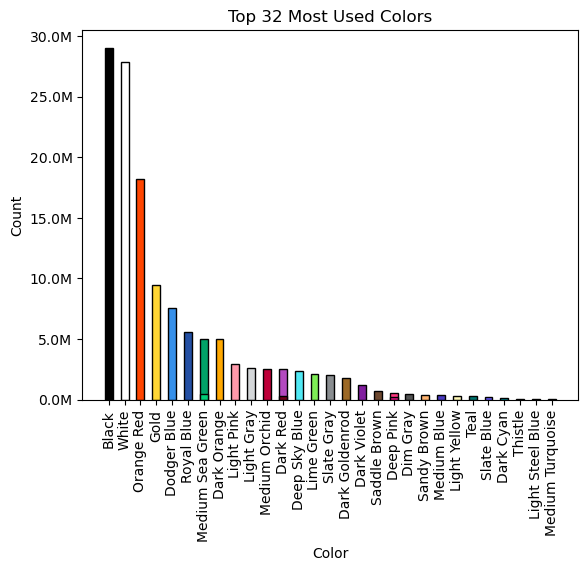

In [8]:
with TqdmCallback(desc="Compute most used colors", total=132224375):
    most_used_color_codes = p_data['color_code'].value_counts().compute()

most_used_colors_hex = most_used_color_codes.index.map(reverse_color_mapping.get)
# print("Top 32 most used colors:")
# for color_code in most_used_colors_hex:
#     print(f"{color_code}: {most_used_color_codes.loc[color_mapping[color_code]]}")
colors = most_used_colors_hex.tolist()
counts = most_used_color_codes.tolist()
color_names = ['Black', 'White', 'Orange Red', 'Gold', 'Dodger Blue', 'Royal Blue', 'Medium Sea Green', 'Dark Orange', 'Light Pink', 'Light Gray','Medium Orchid', 'Dark Red', 'Deep Sky Blue', 'Lime Green', 'Slate Gray', 'Dark Goldenrod', 'Dark Violet', 'Saddle Brown', 'Deep Pink', 'Medium Sea Green', 'Dim Gray', 'Sandy Brown', 'Medium Blue', 'Light Yellow', 'Teal', 'Dark Red', 'Slate Blue', 'Deep Pink', 'Dark Cyan', 'Thistle', 'Light Steel Blue', 'Medium Turquoise']

plt.bar(color_names, counts, color=colors, edgecolor='black', width=0.5)

plt.xticks(rotation=90)
formatter = ticker.FuncFormatter(lambda x, pos: '%1.1fM' % (x * 1e-6))
plt.gca().yaxis.set_major_formatter(formatter)
plt.title('Top 32 Most Used Colors')
plt.xlabel('Color')
plt.ylabel('Count')
plt.show()

## Uncovering Unique Pixels

Pixels that remained untouched after their initial placement – a testament to either their strategic placement or the community's consensus.

In [13]:
with TqdmCallback(desc="Computing pixel placement counts"):
    pixel_placement_counts = p_data.groupby('coordinate').size().compute()

untouched_pixels = pixel_placement_counts[pixel_placement_counts == 1]
untouched_pixel_coordinates = untouched_pixels.index.tolist()

print(f"Number of pixels placed once and never changed: {len(untouched_pixel_coordinates)}")
print("Sample of untouched pixel coordinates:", untouched_pixel_coordinates[:10])

Computing pixel placement counts:   0%|          | 0/61 [00:00<?, ?it/s]

Number of pixels placed once and never changed: 24334
Sample of untouched pixel coordinates: ['-109,395,-109,395', '-113,397,-113,397', '-252,446,-246,447', '-298,-355,-298,-355', '-298,-356,-298,-356', '-299,-358,-298,-358', '101,-469', '124,151,124,151', '149,473,149,473', '150,473,150,473']


In [9]:
comma_count = p_data['coordinate'].str.count(',')
count = (comma_count >= 2).sum().compute()
print("Number of coordinates in the different format:", count)

Number of coordinates in the different format: 30667


In [21]:
comma_counts = p_data['coordinate'].str.count(',')
counts = {}

for num_commas in range(comma_counts.max().compute() + 1):
    count = (comma_counts == num_commas).sum().compute()
    counts[num_commas] = count

for num_commas, count in counts.items():
    print(f"Number of coordinates with {num_commas} comma(s): {count}")

Number of coordinates with 0 comma(s): 0
Number of coordinates with 1 comma(s): 132193708
Number of coordinates with 2 comma(s): 25239
Number of coordinates with 3 comma(s): 5428


In [5]:
suspected_admin = p_data[p_data['coordinate'].str.count(',') >= 2]
print(suspected_admin.compute())

                             user_id                 coordinate  color_code
timestamp                                                                  
2023-07-20 13:25:13.883 UTC   106014     {X: 425, Y: 441, R: 2}           1
2023-07-20 13:26:05.664 UTC   106014     {X: 426, Y: 436, R: 3}           1
2023-07-20 13:32:04.403 UTC   106014     {X: 426, Y: 442, R: 6}           1
2023-07-20 13:38:20.579 UTC  2012874            165,461,166,461           3
2023-07-20 13:38:54.592 UTC  2012874            169,463,170,464           3
...                              ...                        ...         ...
2023-07-25 21:28:00.101 UTC  7410740  {X: -1102, Y: -839, R: 2}           1
2023-07-25 21:28:34.343 UTC  7410740    {X: 289, Y: -985, R: 1}           1
2023-07-25 21:31:16.068 UTC  7410740  {X: -1275, Y: 383, R: 10}           1
2023-07-25 21:32:51.763 UTC  7410740    {X: 181, Y: -987, R: 2}           1
2023-07-25 21:33:03.144 UTC  7410740            43,-989,47,-986           1

[30667 rows

In [52]:
p_data_simplified = p_data[p_data['coordinate'].str.count(',') < 2]


In [53]:
user_pixel_counts = p_data_simplified.groupby('user_id').size().compute()

suspected_bot_user_ids = user_pixel_counts[user_pixel_counts > 450].index

suspected_bot_user_ids = [uid for uid in suspected_bot_user_ids if uid not in admin_user_ids]

suspected_bots_excluding_admins = p_data_simplified[p_data_simplified['user_id'].isin(suspected_bot_user_ids)]


In [60]:
# Use compute() to convert to pandas DataFrame for inspection
print(suspected_bots_excluding_admins.head())


                             user_id coordinate  color_code
timestamp                                                  
2023-07-20 13:01:52.149 UTC  2934886    -64,-34           4
2023-07-20 13:04:44.439 UTC  6882963       78,4           0
2023-07-20 13:04:45.616 UTC  6893043   -161,-30           0
2023-07-20 13:04:47.278 UTC  4393833   -14,-299           7
2023-07-20 13:04:47.316 UTC  7909246  -400,-140           0


In [62]:
suspected_bots_excluding_admins_reset = suspected_bots_excluding_admins.reset_index()
print(suspected_bots_excluding_admins_reset.head())

                     timestamp  user_id coordinate  color_code
0  2023-07-20 13:01:52.149 UTC  2934886    -64,-34           4
1  2023-07-20 13:04:44.439 UTC  6882963       78,4           0
2  2023-07-20 13:04:45.616 UTC  6893043   -161,-30           0
3  2023-07-20 13:04:47.278 UTC  4393833   -14,-299           7
4  2023-07-20 13:04:47.316 UTC  7909246  -400,-140           0


In [28]:
suspected_admin.compute().to_csv('Suspected_admins.csv')

100%|██████████| 30667/30667 [01:17<00:00, 396.62it/s]


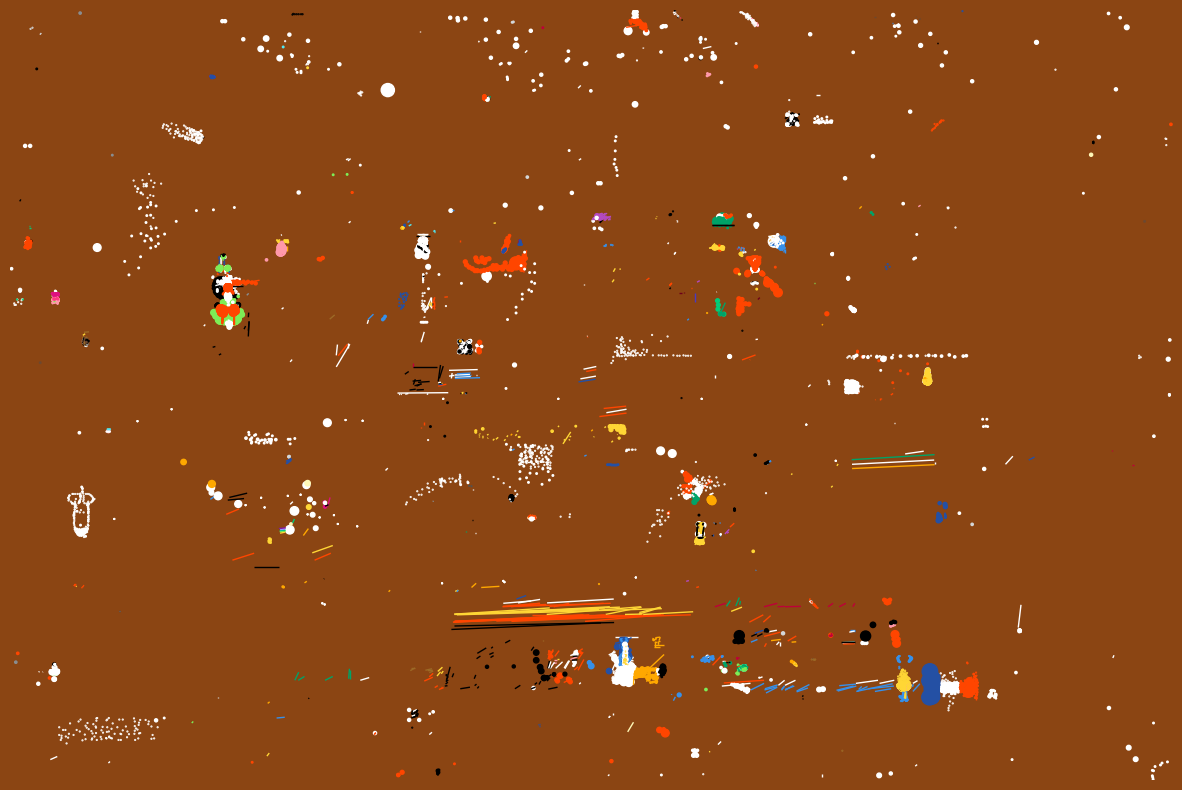

In [71]:
def apply_shape(row, canvas, color_mapping):
    coord = row['coordinate']
    color_idx = row['color_code']
    color_hex = reverse_color_mapping.get(color_idx,'000000').lstrip('#')
    if len(color_hex) != 6:
        raise ValueError(f"Invalid color hex code: {color_hex}")

    color_rgb = tuple(int(color_hex[i:i+2], 16)/255 for i in (0, 2, 4))
    numbers = [int(num) for num in re.findall(r'-?\d+', coord)]
    if coord.startswith('{'):
        x = int(numbers[0])
        y = int(numbers[1])
        radius = int(numbers[2])
        circle = Circle((x,y), radius, color=color_rgb, fill=True)
        canvas.add_patch(circle)
    else:
        vertices = [(numbers[i], numbers[i + 1]) for i in range(0, len(numbers), 2)]
        poly = Polygon(vertices, closed=True, color=color_rgb, fill=True)
        canvas.add_patch(poly)

def plot_admin_impact(suspected_admin, index_to_color):
    fig, canvas = plt.subplots(figsize=(15, 10))
    canvas_width = 3000
    canvas_height = 2000
    canvas.set_xlim(-1500, 1500)
    canvas.set_ylim(-1000, 1000)
    fig.patch.set_facecolor('#8B4513')
    for index, row in tqdm(suspected_admin.iterrows(), total=30667):
        apply_shape(row, canvas, index_to_color)

    plt.axis('off')
    plt.show()
    fig.savefig('Admin_pixels.png', dpi=600, bbox_inches='tight')

suspected_admin_c = suspected_admin.compute()
plot_admin_impact(suspected_admin_c, color_mapping)

In [7]:
p_data_filter = p_data[p_data['coordinate'].str.count(',') < 2]
p_data_filtered = p_data_filter.compute()


In [8]:
suspected_admin = p_data[p_data['coordinate'].str.count(',') >= 2]

# Calculate user pixel counts excluding suspected administrators
user_pixel_counts = p_data[~p_data['user_id'].isin(suspected_admin['user_id'].compute())].groupby('user_id').size().compute()

threshold = 450

# Calculate suspected bots excluding suspected administrators
suspected_bots = user_pixel_counts[user_pixel_counts > threshold]

print(f"Suspected Bots (user_id exceeding {threshold} actions):")
print(suspected_bots)

In [9]:
print(len(p_data_active))

5234783


In [15]:
suspected_bot_actions = p_data[p_data['user_id'].isin(suspected_bots.index)]
print(suspected_bot_actions.head())

In [10]:
suspected_bot_actions_computed = suspected_bot_actions.compute()


100%|██████████| 5234783/5234783 [03:59<00:00, 21862.97it/s]


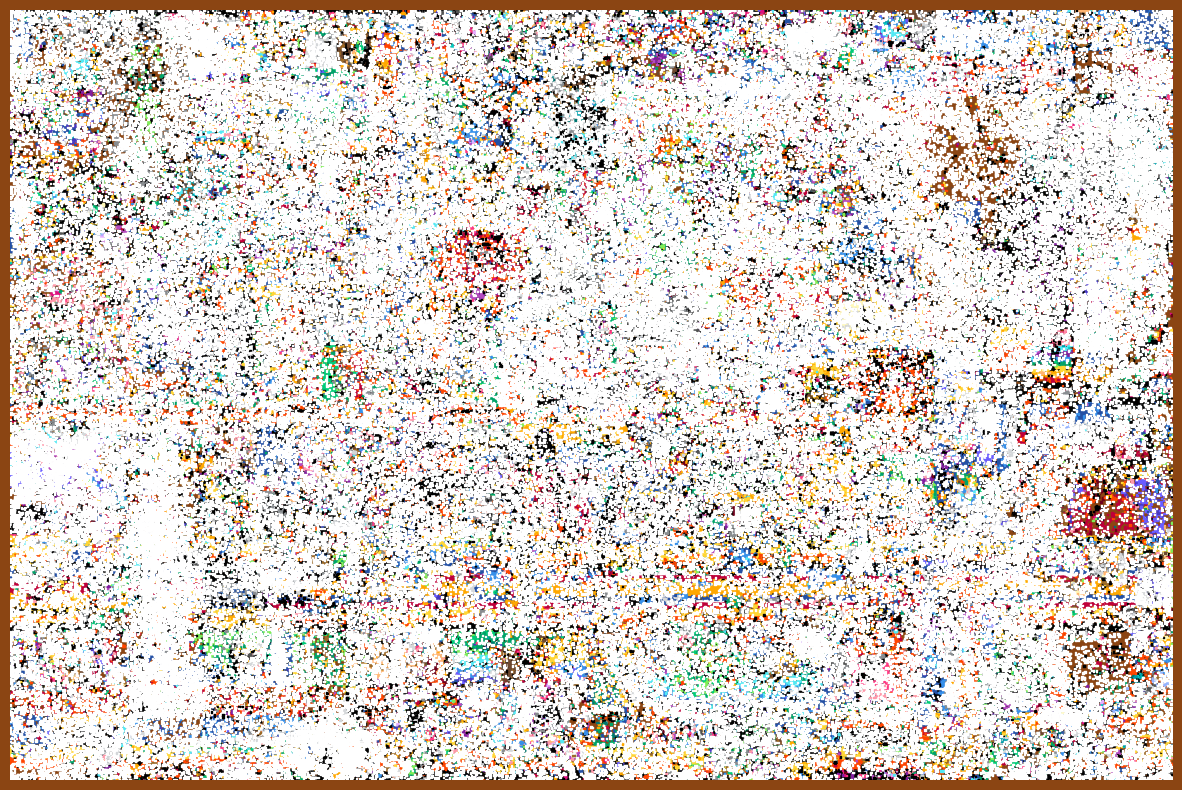

In [48]:

def plot_bot_impact(actions, index_to_color):
    canvas_width = 3000
    canvas_height = 2000
    canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)  # Define the canvas
    
    for _, row in tqdm(actions.iterrows(), total=actions.shape[0]):
        coords = row['coordinate'].split(',')
        if len(coords) != 2:
            continue
        x, y = map(int, coords)
        
        color_hex = index_to_color[row['color_code']].lstrip('#')
        
        color_hex = '{:0>6}'.format(color_hex)
        
        color = tuple(int(color_hex[i:i+2], 16) for i in (0, 2, 4))  # Convert hex to RGB
        
        canvas[y, x] = color 
    
    plt.figure(figsize=(15, 10)) 
    plt.imshow(canvas)
    plt.axis('off')
    plt.show()

plot_bot_impact(suspected_bot_actions_computed, reverse_color_mapping)


In [49]:
fig.savefig('bot_p.png', dpi=600, bbox_inches='tight')

Compute most used colors:   0%|          | 0/61 [00:00<?, ?it/s]

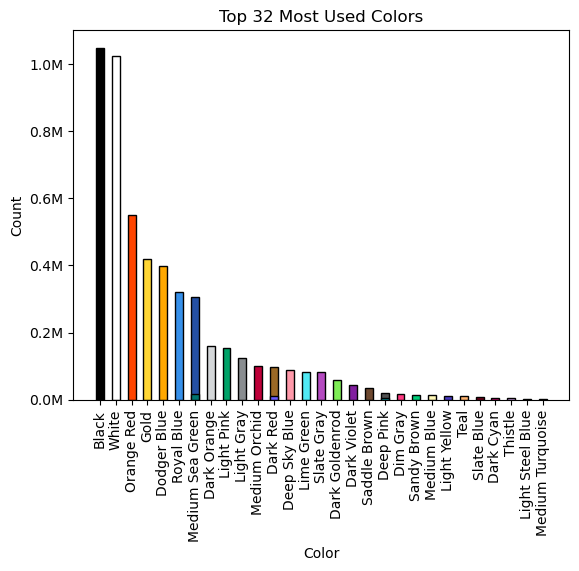

In [46]:
with TqdmCallback(desc="Compute most used colors", total=5234783):
    most_used_color_codes = p_data_active['color_code'].value_counts().compute()

most_used_colors_hex = most_used_color_codes.index.map(reverse_color_mapping.get)
# print("Top 32 most used colors:")
# for color_code in most_used_colors_hex:
#     print(f"{color_code}: {most_used_color_codes.loc[color_mapping[color_code]]}")
colors = most_used_colors_hex.tolist()
counts = most_used_color_codes.tolist()
color_names = ['Black', 'White', 'Orange Red', 'Gold', 'Dodger Blue', 'Royal Blue', 'Medium Sea Green', 'Dark Orange', 'Light Pink', 'Light Gray','Medium Orchid', 'Dark Red', 'Deep Sky Blue', 'Lime Green', 'Slate Gray', 'Dark Goldenrod', 'Dark Violet', 'Saddle Brown', 'Deep Pink', 'Medium Sea Green', 'Dim Gray', 'Sandy Brown', 'Medium Blue', 'Light Yellow', 'Teal', 'Dark Red', 'Slate Blue', 'Deep Pink', 'Dark Cyan', 'Thistle', 'Light Steel Blue', 'Medium Turquoise']

plt.bar(color_names, counts, color=colors, edgecolor='black', width=0.5)

plt.xticks(rotation=90)
formatter = ticker.FuncFormatter(lambda x, pos: '%1.1fM' % (x * 1e-6))
plt.gca().yaxis.set_major_formatter(formatter)
plt.title('Top 32 Most Used Colors')
plt.xlabel('Color')
plt.ylabel('Count')
plt.show()

In [21]:
colors = ['#000000', '#FFFFFF', '#FF4500', '#FFD635', '#3690EA', '#2450A4', '#00A368', '#FFA800', '#FF99AA', '#B44AC0', '#D4D7D9', '#BE0039', '#51E9F4', '#7EED56', '#898D90', '#9C6926', '#811E9F', '#6D482F', '#FF3881', '#00CC78', '#515252', '#FFB470', '#493AC1', '#FFF8B8', '#00756F', '#6D001A', '#6A5CFF', '#DE107F', '#009EAA', '#E4ABFF', '#94B3FF', '#00CCC0']

index_to_color = {idx: color for idx, color in enumerate(colors)}


In [71]:
print(human_actions.head())
print(len(human_actions))

                             user_id coordinate  color_code
timestamp                                                  
2023-07-20 13:00:26.088 UTC  1373288  -199,-235           1
2023-07-20 13:00:43.658 UTC  6540834     0,-298           2
2023-07-20 13:00:43.705 UTC  4454681   -42,-218           1
2023-07-20 13:01:02.487 UTC  4625832  -418,-232           9
2023-07-20 13:01:40.445 UTC  3695034    182,164           2
126954288


In [ ]:
def plot_bot_impact(human_actions, reverse_color_mapping):
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_xlim(-1500, 1500)
    ax.set_ylim(-1000, 1000)
    fig.patch.set_facecolor('#8B4513')
    ax.set_facecolor('#8B4513')
    ax.patch.set_facecolor('#8B4513')
    fig.set_facecolor('#8B4513')

    # Collecting x, y coordinates and colors
    x_coords = []
    y_coords = []
    color_values  = []

    for _, row in tqdm(human_actions.iterrows(), total=126954288):
        coords = row['coordinate'].split(',')
        if len(coords) != 2:
            continue
        x, y = map(int, coords)

        color_idx = row['color_code']
        color_hex = reverse_color_mapping.get(color_idx, '000000').lstrip('#')
        color_rgb = tuple(int(color_hex[i:i+2], 16)/255 for i in (0, 2, 4))  # Normalize RGB values

        # Append coordinates and color for each point
        x_coords.append(x)
        y_coords.append(y)
        color_values.append(color_rgb)
    ax.set_facecolor('#8B4513')
    ax.patch.set_facecolor('#8B4513')
    fig.set_facecolor('#8B4513')
    fig.patch.set_facecolor('#8B4513')
    # Plot all points at once
    ax.scatter(x_coords, y_coords, c=color_values, s=1,marker='s')  # Adjust the size (s) as needed

    plt.axis('off')
    plt.show()
    fig.savefig('bot_pixels.png', dpi=600, bbox_inches='tight')
    # fig.savefig('bot_pixel.png', facecolor=fig.get_facecolor(), edgecolor='none', dpi=600, bbox_inches='tight')




plot_bot_impact(human_actions, reverse_color_mapping)


 63%|██████▎   | 80448626/126954288 [1:04:33<36:22, 21310.11it/s]  

In [67]:
p_data_active.compute()

,user_id,coordinate,color_code
timestamp,,,
2023-07-20 13:01:52.149 UTC,2934886,"-64,-34",4
2023-07-20 13:04:44.439 UTC,6882963,"78,4",0
2023-07-20 13:04:45.616 UTC,6893043,"-161,-30",0
2023-07-20 13:04:47.278 UTC,4393833,"-14,-299",7
2023-07-20 13:04:47.316 UTC,7909246,"-400,-140",0
...,...,...,...
2023-07-25 21:38:33.775 UTC,5218277,"832,242",1
2023-07-25 21:38:33.81 UTC,2808836,"-1495,999",1
2023-07-25 21:38:33.948 UTC,4474439,"-86,-563",1


In [36]:
active_user_ids = p_data_active['user_id'].unique().compute()
admin_user_ids = suspected_admin['user_id'].unique().compute()
admin_and_bot_users = pd.concat([active_user_ids, admin_user_ids])
human_actions = p_data[~p_data['user_id'].isin(admin_and_bot_users.values)]
print(len(human_actions))

126954288


In [60]:
human_actions.compute()

,user_id,coordinate,color_code
timestamp,,,
2023-07-20 13:00:26.088 UTC,1373288,"-199,-235",1
2023-07-20 13:00:43.658 UTC,6540834,"0,-298",2
2023-07-20 13:00:43.705 UTC,4454681,"-42,-218",1
2023-07-20 13:01:02.487 UTC,4625832,"-418,-232",9
2023-07-20 13:01:40.445 UTC,3695034,"182,164",2
...,...,...,...
2023-07-25 21:38:35.386 UTC,552654,"-569,155",1
2023-07-25 21:38:35.512 UTC,4430580,"380,-113",1
2023-07-25 21:38:35.806 UTC,5778781,"450,725",1


In [16]:
# This should convert the index back to a column, typically named 'timestamp' if that was the original column name
suspected_admin_reset = suspected_admin.reset_index()

In [19]:
print(suspected_admin_reset.head())

                     timestamp  user_id              coordinate  color_code
0  2023-07-20 13:25:13.883 UTC   106014  {X: 425, Y: 441, R: 2}           1
1  2023-07-20 13:26:05.664 UTC   106014  {X: 426, Y: 436, R: 3}           1
2  2023-07-20 13:32:04.403 UTC   106014  {X: 426, Y: 442, R: 6}           1
3  2023-07-20 13:38:20.579 UTC  2012874         165,461,166,461           3
4  2023-07-20 13:38:54.592 UTC  2012874         169,463,170,464           3


In [21]:
suspected_admin_reset['timestamp'] = dd.to_datetime(suspected_admin_reset['timestamp'], utc=True)


In [22]:
suspected_admin_reset['hour'] = suspected_admin_reset['timestamp'].dt.hour

# Now you can print or inspect the first few rows to verify
print(suspected_admin_reset.head())

                         timestamp  user_id              coordinate  \
0 2023-07-20 13:25:13.883000+00:00   106014  {X: 425, Y: 441, R: 2}   
1 2023-07-20 13:26:05.664000+00:00   106014  {X: 426, Y: 436, R: 3}   
2 2023-07-20 13:32:04.403000+00:00   106014  {X: 426, Y: 442, R: 6}   
3 2023-07-20 13:38:20.579000+00:00  2012874         165,461,166,461   
4 2023-07-20 13:38:54.592000+00:00  2012874         169,463,170,464   

   color_code  hour  
0           1    13  
1           1    13  
2           1    13  
3           3    13  
4           3    13  


In [44]:
human_actions_reset = human_actions.reset_index()

In [45]:
print(human_actions_reset.head())

                     timestamp  user_id coordinate  color_code
0  2023-07-20 13:00:26.088 UTC  1373288  -199,-235           1
1  2023-07-20 13:00:43.658 UTC  6540834     0,-298           2
2  2023-07-20 13:00:43.705 UTC  4454681   -42,-218           1
3  2023-07-20 13:01:02.487 UTC  4625832  -418,-232           9
4  2023-07-20 13:01:40.445 UTC  3695034    182,164           2


In [48]:
human_actions_reset['timestamp'] = dd.to_datetime(human_actions_reset['timestamp'], utc=True)

In [49]:
human_actions_reset.head

<bound method _Frame.head of Dask DataFrame Structure:
                          timestamp user_id coordinate color_code
npartitions=53                                                   
                datetime64[ns, UTC]   int32     string       int8
                                ...     ...        ...        ...
...                             ...     ...        ...        ...
                                ...     ...        ...        ...
                                ...     ...        ...        ...
Dask Name: assign, 15 graph layers>

In [10]:
suspected_admin = p_data[p_data['coordinate'].str.count(',') >= 2]

# Calculate user pixel counts excluding suspected administrators
user_pixel_counts = p_data[~p_data['user_id'].isin(suspected_admin['user_id'].compute())].groupby('user_id').size().compute()

threshold = 450

# Calculate suspected bots excluding suspected administrators
suspected_bots = user_pixel_counts[user_pixel_counts > threshold]

print(f"Suspected Bots (user_id exceeding {threshold} actions):")
print(suspected_bots)

Suspected Bots (user_id exceeding 450 actions):
user_id
1431       1617
7627        687
8958        565
11766       497
13479       541
           ... 
6734644     457
1298477     605
6791908     519
5634754     451
6265101     455
Length: 8281, dtype: int64


In [13]:
suspected_bot_actions_index = suspected_bot_actions.index.compute()
suspected_admin_index = suspected_admin.index.compute()
suspected_bot_actions_index = suspected_bot_actions_index.tolist()
suspected_admin_index = suspected_admin_index.tolist()

In [14]:
human_data = p_data.loc[~p_data.index.isin(suspected_bot_actions_index)]
human_data = human_data.loc[~human_data.index.isin(suspected_admin_index)]

In [15]:
human_data['timestamp'] = dd.to_datetime(human_data.index)
activity_by_hour_human = human_data.groupby(human_data['timestamp'].dt.hour).size()

# Compute hourly activity counts for suspected bots
suspected_bot_actions['timestamp'] = dd.to_datetime(suspected_bot_actions.index)
activity_by_hour_bots = suspected_bot_actions.groupby(suspected_bot_actions['timestamp'].dt.hour).size()

# Compute hourly activity counts for suspected admins
suspected_admin['timestamp'] = dd.to_datetime(suspected_admin.index)
activity_by_hour_admins = suspected_admin.groupby(suspected_admin['timestamp'].dt.hour).size()

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(activity_by_hour_human.index, activity_by_hour_human, label='Humans', color='green')
plt.plot(activity_by_hour_admins.index, activity_by_hour_admins, label='Suspected Admins', color='blue')
plt.plot(activity_by_hour_bots.index, activity_by_hour_bots, label='Suspected Bots', color='red')

plt.title('Human vs Suspected Admin vs Suspected Bot Activity by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Pixels Placed')
plt.legend()
plt.xticks(range(24))  # Assuming 24-hour format
plt.grid(True)
plt.show()
